<a href="https://colab.research.google.com/github/madhavankv/predictive_maintenance/blob/master/sensor_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (25.0, 15.0)
import seaborn as sns

url='https://raw.githubusercontent.com/madhavankv/predictive_maintenance/master/sensor.csv'

train=pd.read_csv(url)
train.columns


X=train.drop(['machine_status','sensor_15'], axis=1)
X['timestamp'] =  pd.to_datetime(X['timestamp'], format='%d/%m/%Y %H:%M' ,utc='True')
X.columns=[col.replace(' ', '_').lower() for col in X.columns]
X.head()

,unnamed:_0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
0,0,2018-04-01 00:00:00+00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,47.52422,31.11716,1.681353,419.5747,461.8781,466.3284,2.565284,665.3993,398.9862,880.0001,498.8926,975.9409,627.6740,741.7151,848.0708,429.0377,785.1935,684.9443,594.4445,682.8125,680.4416,433.7037,171.9375,341.9039,195.0655,90.32386,40.36458,31.51042,70.57291,30.98958,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889
1,1,2018-04-01 00:01:00+00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,47.52422,31.11716,1.681353,419.5747,461.8781,466.3284,2.565284,665.3993,398.9862,880.0001,498.8926,975.9409,627.6740,741.7151,848.0708,429.0377,785.1935,684.9443,594.4445,682.8125,680.4416,433.7037,171.9375,341.9039,195.0655,90.32386,40.36458,31.51042,70.57291,30.98958,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889
2,2,2018-04-01 00:02:00+00:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,37.86777,48.17723,32.08894,1.708474,420.8480,462.7798,459.6364,2.500062,666.2234,399.9418,880.4237,501.3617,982.7342,631.1326,740.8031,849.8997,454.2390,778.5734,715.6266,661.5740,721.8750,694.7721,441.2635,169.9820,343.1955,200.9694,93.90508,41.40625,31.25000,69.53125,30.46875,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037
3,3,2018-04-01 00:03:00+00:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,38.57977,48.65607,31.67221,1.579427,420.7494,462.8980,460.8858,2.509521,666.0114,399.1046,878.8917,499.0430,977.7520,625.4076,739.2722,847.7579,474.8731,779.5091,690.4011,686.1111,754.6875,683.3831,446.2493,166.4987,343.9586,193.1689,101.04060,41.92708,31.51042,72.13541,30.46875,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250
4,4,2018-04-01 00:04:00+00:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,39.48939,49.06298,31.95202,1.683831,419.8926,461.4906,468.2206,2.604785,663.2111,400.5426,882.5874,498.5383,979.5755,627.1830,737.6033,846.9182,408.8159,785.2307,704.6937,631.4814,766.1458,702.4431,433.9081,164.7498,339.9630,193.8770,101.70380,42.70833,31.51042,76.82291,30.98958,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889


In [0]:
machinestatus={'NORMAL':0,'RECOVERING':1,'BROKEN':2}
train.machine_status=[machinestatus[item] for item in train.machine_status ]
y=train.machine_status

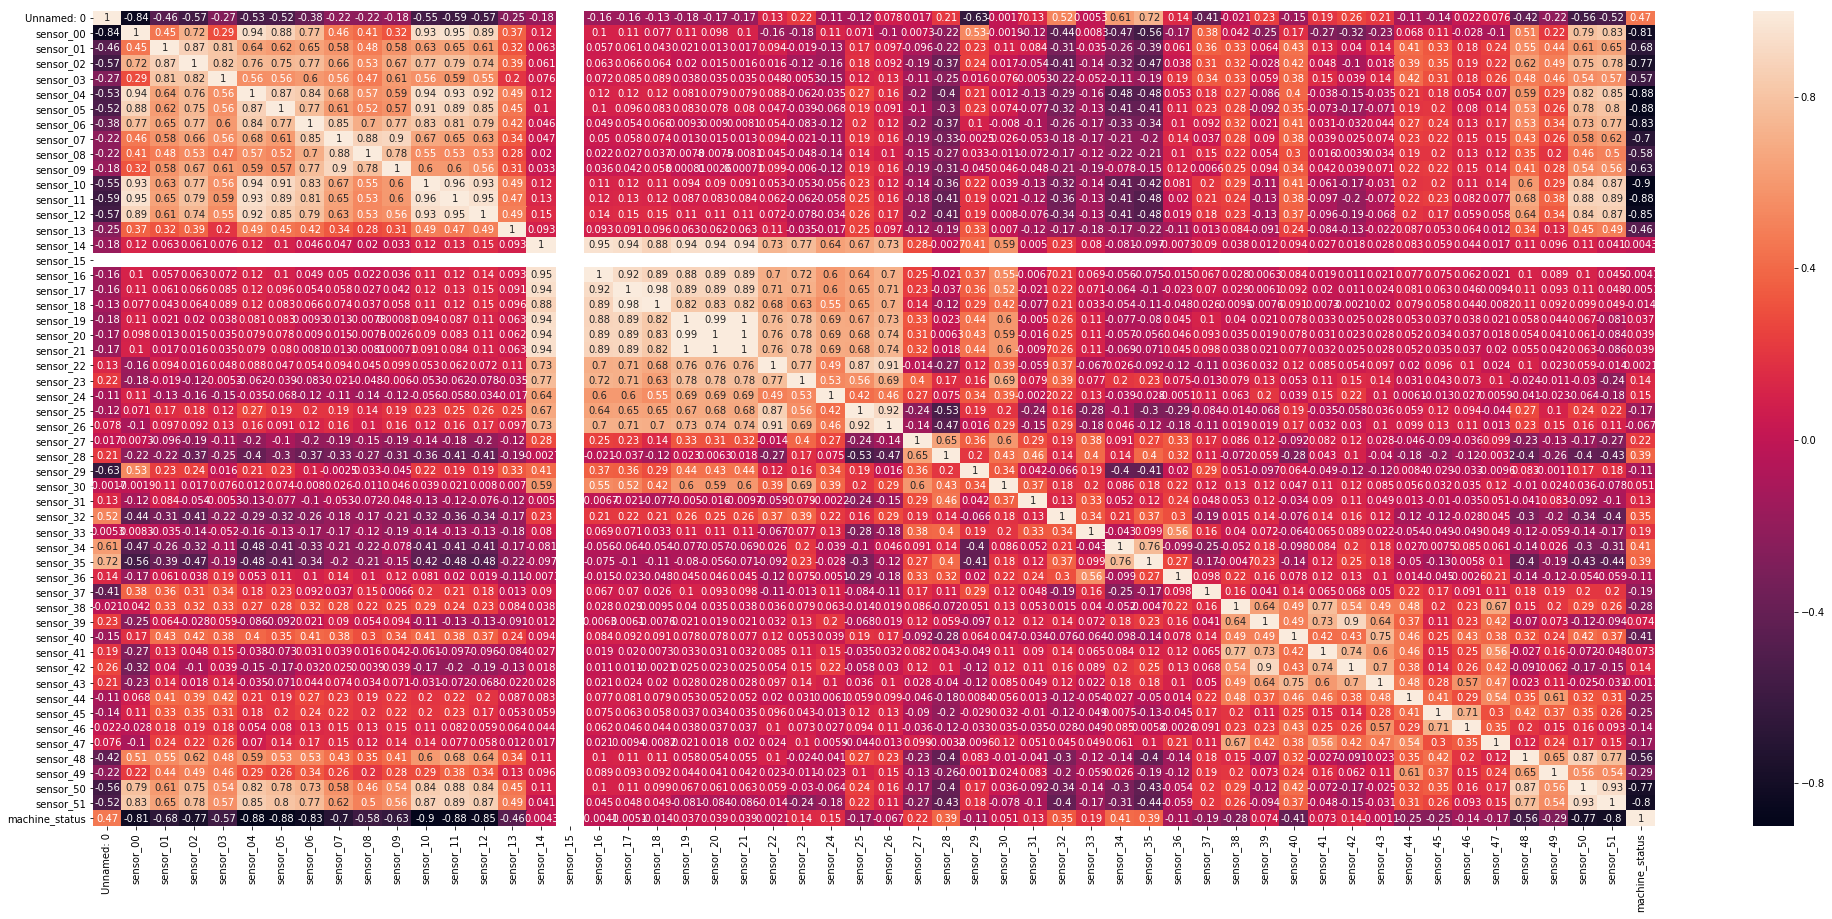

In [0]:
plt.rcParams['figure.figsize'] = (35.0, 15.0)
corr=train.corr()
sns.heatmap(corr,annot=True)

In [0]:
#missing value counts in each of these columns
miss = X.isnull().sum()/len(train)
miss = miss[miss > 0]
miss.sort_values(inplace=True)
miss

sensor_13    0.000102
sensor_43    0.000102
sensor_42    0.000102
sensor_41    0.000102
sensor_40    0.000102
sensor_39    0.000102
sensor_38    0.000102
sensor_46    0.000102
sensor_12    0.000102
sensor_11    0.000102
sensor_10    0.000102
sensor_47    0.000102
sensor_48    0.000102
sensor_49    0.000102
sensor_05    0.000102
sensor_04    0.000102
sensor_03    0.000102
sensor_02    0.000102
sensor_44    0.000102
sensor_45    0.000102
sensor_01    0.001967
sensor_09    0.002137
sensor_51    0.003663
sensor_50    0.005189
sensor_06    0.008139
sensor_07    0.008614
sensor_08    0.023876
sensor_00    0.126297
dtype: float64

In [0]:
X.info()
X.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29486 entries, 0 to 29485
Data columns (total 53 columns):
unnamed:_0    29486 non-null int64
timestamp     29486 non-null datetime64[ns, UTC]
sensor_00     25762 non-null float64
sensor_01     29428 non-null float64
sensor_02     29483 non-null float64
sensor_03     29483 non-null float64
sensor_04     29483 non-null float64
sensor_05     29483 non-null float64
sensor_06     29246 non-null float64
sensor_07     29232 non-null float64
sensor_08     28782 non-null float64
sensor_09     29423 non-null float64
sensor_10     29483 non-null float64
sensor_11     29483 non-null float64
sensor_12     29483 non-null float64
sensor_13     29483 non-null float64
sensor_14     29486 non-null float64
sensor_16     29486 non-null float64
sensor_17     29486 non-null float64
sensor_18     29486 non-null float64
sensor_19     29486 non-null float64
sensor_20     29486 non-null float64
sensor_21     29486 non-null float64
sensor_22     29486 non-null f

,unnamed:_0,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
count,29486.000000,25762.000000,29428.000000,29483.000000,29483.000000,29483.000000,29483.000000,29246.000000,29232.000000,28782.000000,29423.000000,29483.000000,29483.000000,29483.000000,29483.000000,29486.000000,29486.000000,29486.000000,29486.000000,29486.000000,29486.000000,29486.000000,29486.000000,29486.000000,29486.000000,29486.000000,29486.000000,29486.000000,29486.000000,29486.000000,29486.000000,29486.000000,29486.000000,29486.000000,29486.000000,29486.000000,29486.000000,29486.000000,29483.000000,29483.000000,29483.000000,29483.000000,29483.000000,29483.000000,29483.000000,29483.000000,29483.000000,29483.000000,29483.000000,29483.000000,29333.000000,29378.000000
mean,20992.772299,2.181883,47.369377,49.510616,42.904065,522.007921,64.645398,11.660386,14.648179,14.455368,13.715426,32.191593,37.325670,25.903816,6.176430,413.130650,455.715563,455.859766,2.470963,653.816045,392.274257,864.209170,480.685930,955.878665,619.396139,705.556717,805.657731,492.550908,957.271603,760.440587,672.043281,902.975624,780.847533,534.275675,175.301030,354.995769,470.591620,99.788654,48.042840,36.694239,64.353546,35.626206,36.076467,43.531307,41.994367,45.776254,44.612284,41.425712,127.184680,58.649971,178.814574,171.095239
std,28488.850800,0.654256,3.896905,4.373001,2.689221,214.021627,31.145260,4.028792,4.633691,4.001857,4.303317,15.813827,18.857949,14.042337,6.143583,19.678044,21.761841,19.455830,0.170337,35.283492,19.546207,45.084654,31.915202,61.099559,45.939737,64.257094,67.982132,59.407144,178.807396,76.617417,38.238713,185.909335,72.066914,62.822121,32.307830,53.549155,264.298344,22.765294,13.411612,16.873011,24.185342,12.840182,12.707313,14.625338,12.185661,17.294056,17.713922,10.957629,69.129556,24.078075,79.057683,71.585480
min,0.000000,0.000000,22.439240,34.505207,33.289930,2.873264,0.000000,0.014468,0.000000,0.028935,0.007234,0.000000,0.000000,0.000000,0.000000,97.190110,115.114100,171.885500,0.351085,0.000000,67.826080,155.302200,105.813000,55.784790,101.642300,117.251500,59.828630,0.000000,110.612300,10.930870,11.111110,28.125000,17.209180,37.891430,80.040120,73.322270,25.148870,0.000000,27.343748,21.354166,27.864580,21.354166,23.437500,27.604166,26.620370,26.331020,27.777779,27.777779,27.199070,27.777779,28.067129,28.067129
25%,7371.250000,2.336516,45.225690,48.914930,41.449650,603.588000,68.850715,13.049770,16.073500,15.263310,14.822050,34.856700,39.773920,19.322175,1.334836,408.245525,450.089550,449.690100,2.399444,650.012975,389.972000,858.899425,459.934175,947.975825,612.609850,650.596750,750.870050,455.961325,792.237450,739.423800,656.944500,802.083300,736.745950,480.875000,160.647125,322.419800,249.465825,88.401310,41.927080,30.208330,53.385410,30.989582,31.250000,37.760410,35.011574,36.168980,37.615742,36.747684,67.997690,44.849540,161.747700,165.219900
50%,14742.500000,2.425058,47.829860,51.041664,43.142361,629.976800,76.744360,13.317420,16.167530,15.530960,15.082470,38.952480,45.247810,32.777590,5.113669,418.307550,460.259250,457.411300,2.482465,662.256350,397.416000,874.699450,464.567100,950.208800,623.262950,721.990350,840.816300,495.861400,1040.294000,774.306600,674.074000,917.187400,783.252350,549.826650,167.720200,340.913150,318.087000,101.574800,47.395830,34.375000,63.020830,34.114580,34.114580,41.666660,40.509260,42.245370,41.956017,40.219910,124.421300,53.240740,199.942100,193.865700
75%,22113.750000,2.455556,50.303820,52.256943,44.965275,637.268600,82.445350,13.534430,16.247110,15.697340,15.11

In [0]:
from sklearn.model_selection import train_test_split 
train_X, val_X, train_y, val_y = train_test_split(X,y,random_state=1)

In [0]:
from sklearn.metrics import mean_absolute_error

#  XGBoost model
from numpy import loadtxt
from xgboost import XGBRegressor
def score_dataset(train_X, val_X, train_y, val_y):
    my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=4)
    my_model.fit(train_X,train_y,early_stopping_rounds=5,eval_set=[(val_X, val_y)], verbose=False)
    preds = my_model.predict(val_X)
    return mean_absolute_error(val_y, preds)


In [0]:
from sklearn.impute import SimpleImputer


train_X_without_categoricals = train_X.select_dtypes(exclude=['object','datetime64[ns, UTC]'])
X_val_without_categoricals = val_X.select_dtypes(exclude=['object','datetime64[ns, UTC]'])
# Imputation
my_imputer = SimpleImputer()
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(train_X_without_categoricals))
imputed_X_valid = pd.DataFrame(my_imputer.transform(X_val_without_categoricals))

# Imputation removed column names; put them back
imputed_X_train.columns =train_X_without_categoricals.columns
imputed_X_valid.columns =X_val_without_categoricals.columns
print("MAE from Approach  (Imputation):")
print(score_dataset(imputed_X_train, imputed_X_valid, train_y, val_y))

MAE from Approach  (Imputation):
[02:03:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


0.0034350343432623088


/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


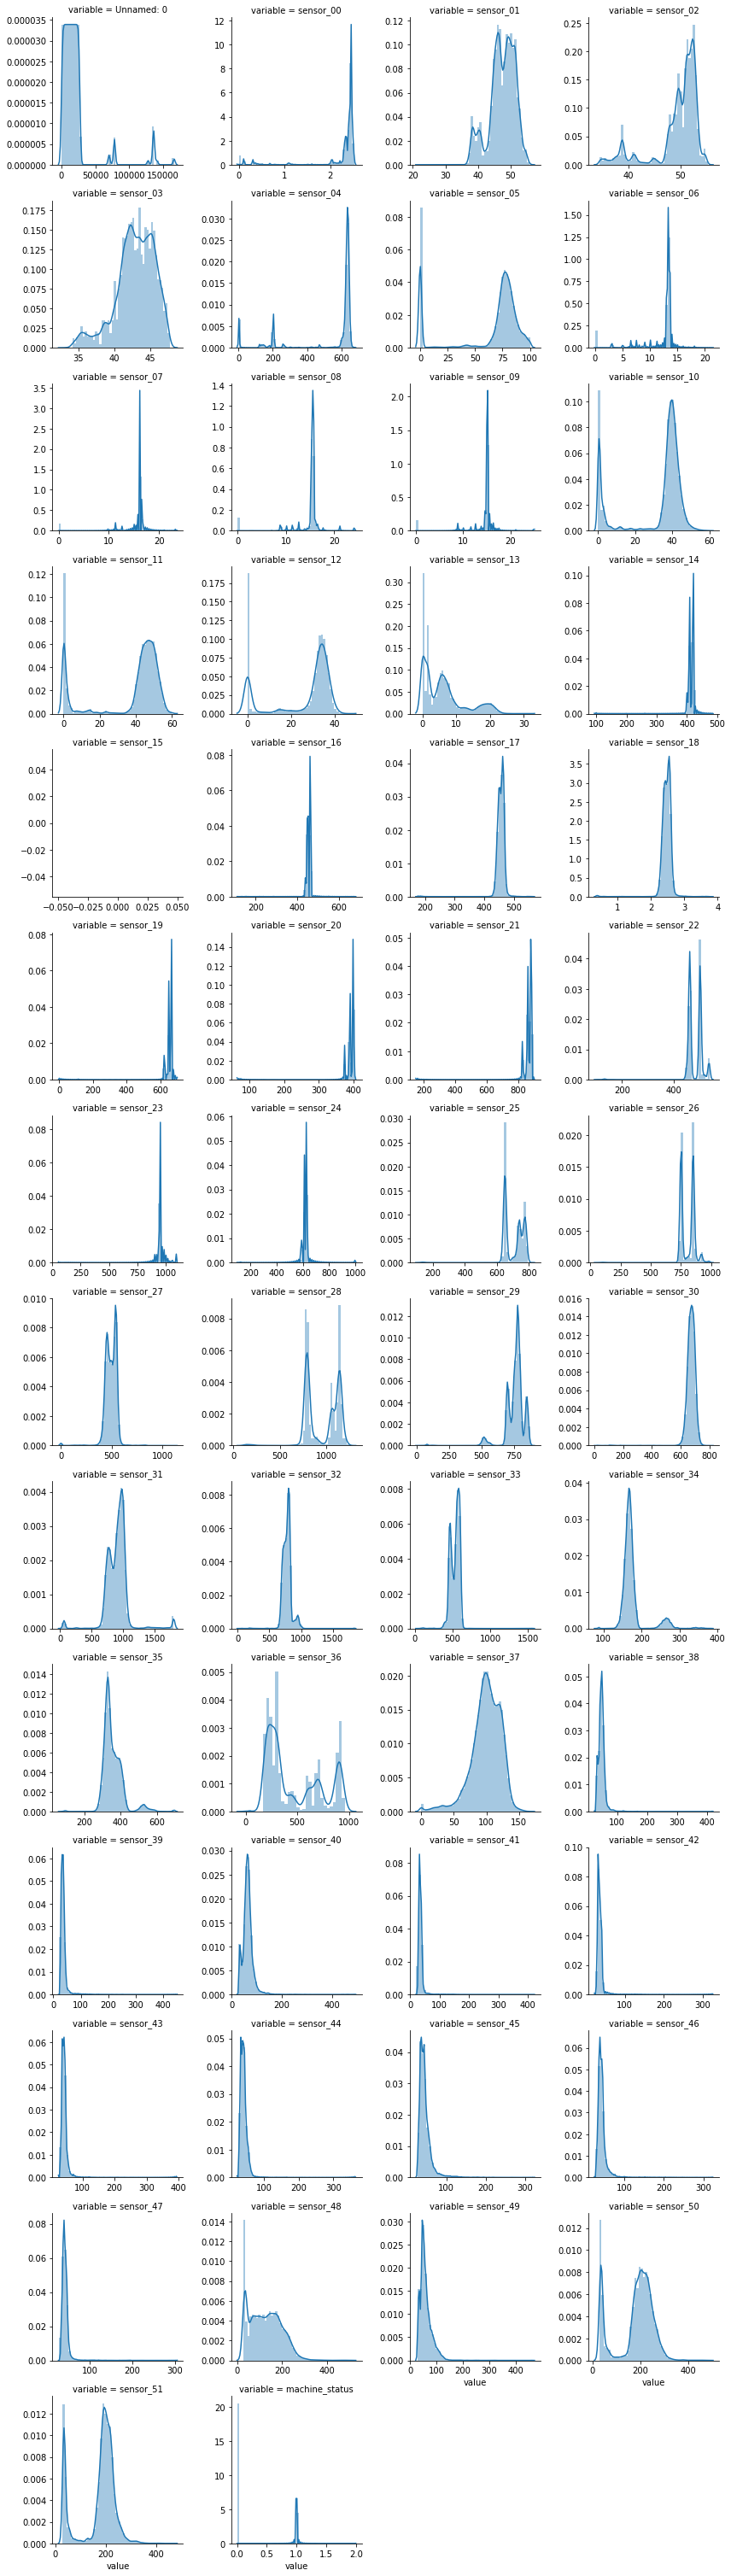

In [0]:
#create numeric plots
num = [f for f in train.columns if train.dtypes[f] != 'object']

nd = pd.melt(train, value_vars = num)
n1 = sns.FacetGrid (nd, col='variable', col_wrap=4, sharex=False, sharey = False)
n1 = n1.map(sns.distplot, 'value')
n1